# Guassian mixture intra-song clustering for identification of "main" beats

Generate a few clusters

If $X_1, \ldots, X_n$ are i.i.d. normal, then the $1 - \alpha$ confidence region is a circle of radius $r$ where
$$P(X_1^2 + \cdots + X_n^2 \leq r^2) =1 - \alpha$$
i.e. given by the square root of the $1-\alpha$ quantile for the chi-squared distribution with $n$ d.f.

A multivariate normal distribution $Y$ with covariance $\Sigma = U S U^t$ is transformed from a standard one $X$ by $Y = AX$ where $A = U S^{1/2}$.  The unit circle is transformed to an ellipse with axes given by the columns of $U$ and axis lengths by $S$.

In [226]:
from matplotlib.patches import Ellipse
import scipy, math
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt


def get_ellipse_patch(center, cov, confidence=0.95):
    # Figure out number of stdevs for confidence
    scale = math.sqrt(scipy.stats.chi2.ppf(q=confidence, df=center.shape[0]))
    
    u, s, vh = np.linalg.svd(cov)
    th = np.arccos(np.dot(np.array([1, 0]), u[:,0])) * 180 / np.pi
    if np.linalg.det(u) < 0:
        th = -th
    return Ellipse((center[0], center[1]), np.sqrt(s[0]) * scale * 2, np.sqrt(s[1])* scale * 2, angle=th, alpha=0.5, color='red')




def ellipse_contains_points(center, covariance, points, confidence=0.95):
    u, s, vh = np.linalg.svd(covariance)
    a = u @ np.diag(np.sqrt(s))
    return np.linalg.norm((points - center) @ np.linalg.inv(a).T, axis=1) ** 2 < scipy.stats.chi2.ppf(q=confidence, df=center.shape[0])
    



# Returns an list of patches, a Numpy array of containment data
def get_patches(gm, confidence, pts):
    patches = []
    contains = []
    for i in range(gm.means_.shape[0]):
        e = get_ellipse_patch(gm.means_[i], gm.covariances_[i], confidence=confidence)
        patches.append(e)
        contains.append(ellipse_contains_points(gm.means_[i], gm.covariances_[i], pts, confidence))

    return patches, np.stack(contains, axis=0)



def winnow_components(data, start=10):
    for i in range(start, 0, -1):
        gm = GaussianMixture(n_components=i)
        gm.fit(data)
        # If i = 1, then we are done anyway, so break
        if i == 1:
            break

        contains = []
        for j in range(i):
            contains.append(ellipse_contains_points(gm.means_[j], gm.covariances_[j], data))
        contains = np.stack(contains)

        # Check if there are any overlaps, if so, continue
        if (contains.sum(axis=0) <= 1).prod().item() != 1:
            continue
        # Check if any ellipses contain less than 10% of data points
        if (contains.sum(axis=1) >= data.shape[0]/10).prod().item() != 1:
            continue
        # Otherwise, we are done
        return gm, i
        
    return gm, i


(1000, 2)


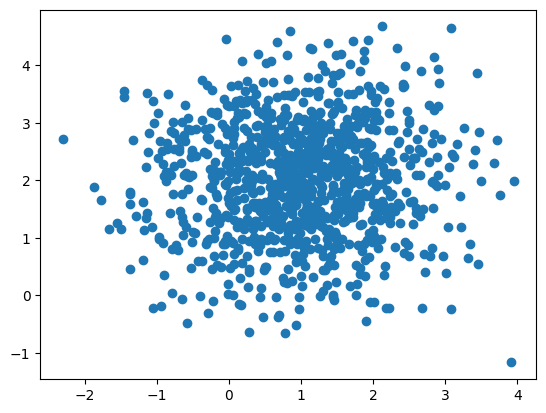

In [234]:


x1 = np.random.normal(loc=1.0, scale=1.0, size=1000)
y1 = np.random.normal(loc=2.0, scale=1.0, size=1000)


u, s, vh = np.linalg.svd(a)

#x = np.concatenate([x1, x2])
#y = np.concatenate([y1, y2])

x = x1
y = y1

plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)


In [235]:

#bgm = BayesianGaussianMixture(n_components=2)
gm = GaussianMixture(n_components=1)


gm.fit(data)
#bgm.fit(data)

print(gm.means_, gm.covariances_)

#print(bgm.means_.shape)

# (patch, data index)
patches, coverage = get_patches(gm, 0.95, data)
total_coverage = np.sum(coverage, axis=0) != 0
num_covered = np.sum(total_coverage)

valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()

overlapped = (coverage.sum(axis=0) > 1).sum()

p = patches[0]
print((p.contains_points(data) == (ellipse_contains_points(gm.means_[0], gm.covariances_[0], data))).sum())

print(data.shape[0])
print(ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum())

# TODO something is wrong here.
print(f"Num covered: {num_covered/data.shape[0]}, valid covered: {valid_covered/data.shape[0]}, overlapped: {overlapped/data.shape[0]}")

# plt.figure()
# ax = plt.gca()
# ax.set_xlim([-5, 5])
# ax.set_ylim([-5, 5])


# plt.scatter(x, y, alpha=0.7)
# for p in patches:
#     ax.add_patch(p)

[[0.97757135 2.00507884]] [[[1.03530598 0.05313266]
  [0.05313266 0.99516394]]]
956
1000
951
Num covered: 0.951, valid covered: 0.951, overlapped: 0.0


My conclusion from the below is that the patches "contains points" is buggy as shit.

In [229]:
p = patches[0]
print((p.contains_points(data) == (ellipse_contains_points(gm.means_[0], gm.covariances_[0], data))).sum())

print(data.shape[0])
print(f"patch way: {p.contains_points(data).sum()}")
print(f"my way: {ellipse_contains_points(gm.means_[0], gm.covariances_[0], data).sum()}")


965
1000
patch way: 986
my way: 951


In [230]:
gm, i = winnow_components(data)
i

1

(1500, 2)


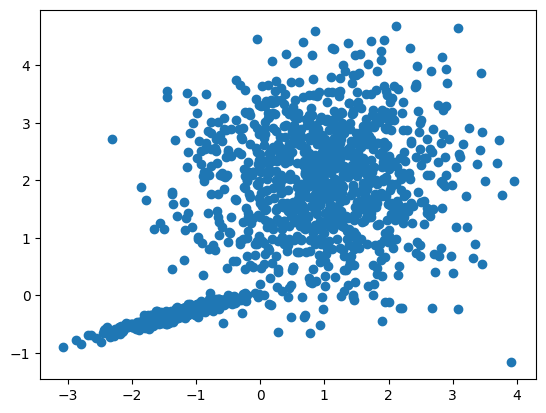

In [236]:
x2 = np.random.normal(loc=-1.0, scale=0.5, size=500)
y2 = np.random.normal(loc=-1.0, scale=0.5, size=500)

a = np.array([[3,1],[1,0]])/3
v = np.concatenate([x2[:, None], y2[:, None]], axis=1) @ a
x2, y2 = v[:,0], v[:,1]


x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



[[ 0.98470923  2.01441795]
 [-1.32903802 -0.33688872]] [[[1.02844208 0.03832621]
  [0.03832621 0.9798604 ]]

 [[0.27037236 0.07922672]
  [0.07922672 0.02589986]]]
Num covered: 0.956, valid covered: 0.956, overlapped: 0.006


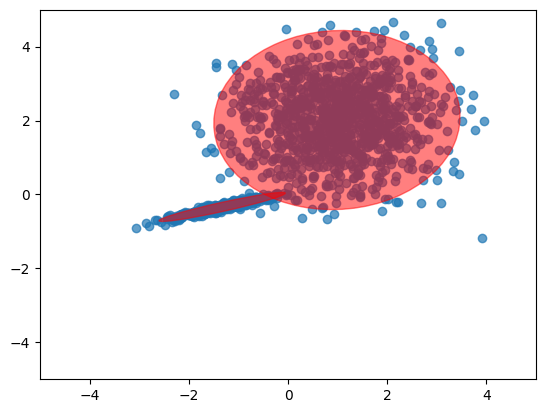

In [237]:

#bgm = BayesianGaussianMixture(n_components=2)
gm = GaussianMixture(n_components=2)


gm.fit(data)
#bgm.fit(data)

print(gm.means_, gm.covariances_)

#print(bgm.means_.shape)

# (patch, data index)
patches, coverage = get_patches(gm, 0.95, data)
total_coverage = np.sum(coverage, axis=0) != 0
num_covered = np.sum(total_coverage)

valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()

overlapped = (coverage.sum(axis=0) > 1).sum()


print(f"Num covered: {num_covered/data.shape[0]}, valid covered: {valid_covered/data.shape[0]}, overlapped: {overlapped/data.shape[0]}")

plt.figure()
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)

In [238]:
gm, i = winnow_components(data)
i

1

(1500, 2)


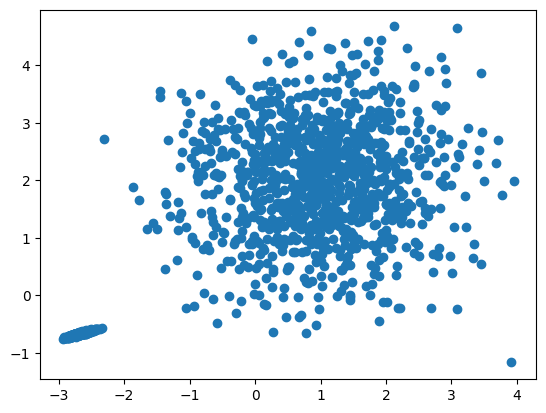

In [242]:
x3 = np.random.normal(loc=-2.0, scale=0.1, size=500)
y3 = np.random.normal(loc=-2.0, scale=0.1, size=500)

a = np.array([[3,1],[1,0]])/3
v = np.concatenate([x3[:, None], y3[:, None]], axis=1) @ a
x3, y3 = v[:,0], v[:,1]


x = np.concatenate([x1, x3])
y = np.concatenate([y1, y3])


plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)



2

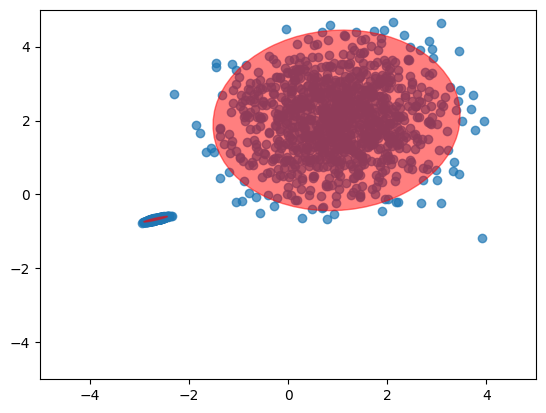

In [244]:
gm = GaussianMixture(n_components=2)
gm.fit(data)


plt.figure()
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

patches, coverage = get_patches(gm, 0.95, data)

plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)




gm, i = winnow_components(data)
i

Note the following "bug" (not sure if bug?) -- something about changing axes limits affecting the "transform stack", see https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html

True
False


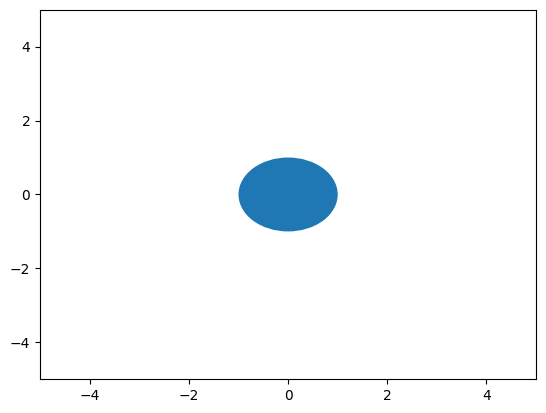

In [245]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


ax = plt.gca()

c = Circle(xy=(0,0), radius=1)
ax.add_patch(c)

print(c.contains_point((0,0)))

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

print(c.contains_point((0,0)))

# Get measure data

In [83]:
def beat_frames_to_toy(frames, len, target_len):
    x = np.zeros(len + ((target_len - len) % target_len))
    x[frames] = 1
    x = x.reshape((target_len, -1))
    x = x.max(axis=1)
    return x

In [132]:
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
#from groove.embedding import beat_frames_to_toy
import numpy as np

file = "milaklaw"

raw, proc, sr = get_measures(file, smooth_power)
bf, nf = get_beat_frames(proc, sr, beat_peaks)

In [85]:
frames = np.array([4,4,7,9,11])
beat_frames_to_toy(frames, 12, 6)


array([0., 0., 1., 1., 1., 1.])

In [119]:
out = []
hashable = []
for i in range(len(bf)):
    a = beat_frames_to_toy(bf[i], nf[i], 24)
    out.append(a)
    hashable.append(tuple(a.tolist()))

data = np.stack(out)
data.shape

(179, 24)

In [131]:
import collections
counter = collections.Counter(hashable)

counter.values()
#counter.most_common(5)

dict_values([17, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 14, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 9, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [113]:
beat_frames_to_toy(bf[20], nf[20], 12)

array([1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.])

[8.26262077 8.01180576]


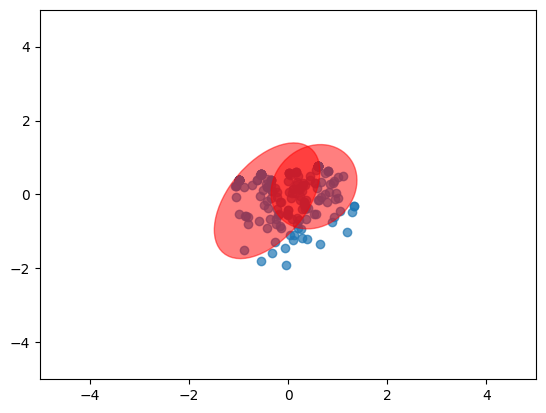

In [122]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
gm = GaussianMixture(n_components=2)


pca.fit(data)

print(pca.singular_values_)
red_data = pca.transform(data)

gm.fit(red_data)

patches, coverage = get_patches(gm, 0.95, red_data)

plt.figure()
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])



plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
for p in patches:
    ax.add_patch(p)


#gm.fit(data)
#gm.means_.round()

Some rules for choosing the number of components:
1) If there are overlaps between the 95%ile circles, we should reduce.
2) If any circles don't cover 10%, we reduce.

So, start with more, then reduce.

In [136]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

gm = GaussianMixture(n_components=3)


gm.fit(data)

gm.means_

array([[1.        , 0.10227234, 0.        , 0.04545838, 0.03409078,
        0.03409078, 0.96590922, 0.05681797, 0.03409078, 0.39772569,
        0.32954418, 0.05682176, 0.56818344, 0.01136359, 0.02272719,
        0.98863641, 0.        , 0.06818153, 0.92045487, 0.05681797,
        0.        , 0.78409172, 0.04545437, 0.01136359],
       [0.92308225, 0.        , 0.02563893, 0.56404838, 0.15383357,
        0.25638929, 0.92308321, 0.02563893, 0.        , 0.56405732,
        0.53850634, 0.2307418 , 0.87171606, 0.17956127, 0.02563893,
        0.69233216, 0.74352946, 0.25638935, 0.84616636, 0.10255592,
        0.15383357, 0.76924887, 0.07691679, 0.        ],
       [0.46150273, 0.48080178, 0.03846414, 0.2500162 , 0.11539243,
        0.        , 0.63459065, 0.09616036, 0.03846414, 0.4615692 ,
        0.30764656, 0.17308864, 0.61542556, 0.17302206, 0.01923207,
        0.40380631, 0.34617689, 0.        , 0.78844722, 0.15385642,
        0.01923207, 0.7115195 , 0.17308864, 0.01923207]])

In [19]:

score = []

for i in range(1, 11):

    gm = GaussianMixture(n_components=i)
    gm.fit(data)


#     # (patch, data index)
#     # TODO doesnt work in more tha n2d...
#     patches, coverage = get_patches(gm, 0.95)
#     total_coverage = np.sum(coverage, axis=0) != 0
#     num_covered = np.sum(total_coverage)

#     valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
#     valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()
#     overlapped = (coverage.sum(axis=0) > 1).sum()

#     score.append((valid_covered - overlapped)/data.shape[0])

# print(score)